# Libraries and utilities

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.mode.chained_assignment = None

In [3]:
# original dataset made public to make this ipynb universal
DATASET_URL = 'https://drive.google.com/file/d/14YOdY371xFEwnfsvKGcp9K-aj8FRe-XO/view?usp=sharing'
DATASET_PROCESSED_URL = 'https://drive.google.com/uc?id=' + DATASET_URL.split('/')[-2]
MAX_EVENTS_SEQ_COUNT = 3

# Exploration and research

## Original dataset

In [4]:
df = pd.read_csv(DATASET_PROCESSED_URL)

In [5]:
df.sample(10)

,userid,user_state,event_name,event_attributes,event_created_date,event_platform,device_manufacture,device_model
13234,010b4bb51c18bac9bdd50a2361cc5bce,CA,Account Setup Profile Skip,"{""Screen"":""Address""}",2022-03-13 19:58:42,ios,Apple,"iPhone14,3"
5315,dd3c7c5c898a4e6a4ed78d6e2c526bed,TX,Order,"{""Premium Membership"":""True""}",2022-02-19 06:54:33,outofband,NaN,NaN
21310,64b11b91d10d9b18e395f1870a070788,CA,Chat Conversation Started,{},2022-04-10 18:30:42,android,samsung,SM-G781U
15709,1ebd9a46e9d38ac548d26c24475c184a,FL,Add Vehicle Success,"{""Make"":""Kia"",""Model"":""Soul"",""Color"":""Gray"",""Y...",2022-03-21 11:28:59,android,motorola,moto g play (2021)
7875,feeb75def9523b6c8c1d804267988c0d,IL,Sign Up Success,"{""Method"":""Google""}",2022-03-02 02:40:57,ios,Apple,"iPhone14,3"
21272,b3b25e224b961d410151a64011aff345,DE,Order,"{""Premium Membership"":""True""}",2022-04-10 17:06:16,outofband,NaN,NaN
16349,e4d57f979e61c8e96675905da8cb2994,TX,Wallet Opened,{},2022-03-24 13:27:10,android,samsung,SM-A205U
7424,e4d57f979e61c8e96675905da8cb2994,TX,Add Vehicle Success,"{""Make"":""Honda"",""Model"":""CR-V"",""Color"":""Silver...",2022-02-21 22:41:32,android,samsung,SM-A205U
13220,424090309305e8b36ebf4e45490d8699,IL,Wallet Opened,{},2022-03-13 19:26:56,ios,Apple,"iPhone13,2"
11719,d237ae5d89292fa9aaf6c0ac59d4ec58,TX,Order,"{""Premium Membership"":""True""}",2022-03-09 07:03:37,outofband,NaN,NaN


In [6]:
print(f'Shape of dataframe: {df.shape}')

Shape of dataframe: (23357, 8)


In [7]:
df.describe()

,userid,user_state,event_name,event_attributes,event_created_date,event_platform,device_manufacture,device_model
count,23357,23286,23357,23357,23357,23357,15847,15847
unique,3540,49,23,2309,20452,3,22,290
top,627f50253b42607513a1c93bb68201ad,CA,Order,"{""Premium Membership"":""True""}",2022-03-16 08:20:51,ios,Apple,"iPhone12,1"
freq,498,8627,6116,5451,17,9586,9586,1489



*  We have 23357 records about 3540 users



In [8]:
df.isnull().sum()

userid                   0
user_state              71
event_name               0
event_attributes         0
event_created_date       0
event_platform           0
device_manufacture    7510
device_model          7510
dtype: int64

* There are some nulls that probably do not impact on target significantly

In [9]:
number_of_unique_sequences_per_user_id, number_of_subsribed_users, number_of_subriscription_cancellations=\
(df['userid'].nunique(),
 df[(df['event_name'] == 'Subscription Premium') | (df['event_name'] == 'Subscription Premium Renew')]['userid'].nunique(),
 df[df['event_name'] == 'Subscription Premium Cancel']['userid'].nunique())
print(f'Number of unique event sequences (users): {number_of_unique_sequences_per_user_id},'
      f'\nNumber of all subsribed users for timeline (at least that have actual data from event): {number_of_subsribed_users}',
      f'\nNumber of subscription cancellations (also that we are aware of from dataset): {number_of_subriscription_cancellations}')

Number of unique event sequences (users): 3540,
Number of all subsribed users for timeline (at least that have actual data from event): 776 
Number of subscription cancellations (also that we are aware of from dataset): 251


In [10]:
cancel_id = (df[df['event_name'] == 'Subscription Premium Cancel']['userid'].unique())
sub_id = (df[(df['event_name'] == 'Subscription Premium') | (df['event_name'] == 'Subscription Premium Renew')]['userid'].unique())

_ = df[~(df['userid'].isin(sub_id)) & (df['userid'].isin(cancel_id))]['userid'].nunique()

print(f'Number of users that were actually subscribed but we are not aware of them directly from event subscription data: {_}')

Number of users that were actually subscribed but we are not aware of them directly from event subscription data: 18


Data insights:
* Data is a bit dirty: it may not contain currently subscribed users.
* We can't be sure that the user has not been unsubscribed within several days after the dataset ends.


Our suggestion is to use the data only for the users that were subscribed. We can get this insight having two cases:
* User has canceled the subscription and we have such an event in the dataset.
* User has not canceled the subscription, but there are events that say about obtaining a premium subscription directly or via renewal.

Raw event count aggregation corellation with target

In [11]:
data = df.groupby(['userid','event_name']).size().unstack().fillna(0)
cols = data.columns
data[cols] = data[cols].astype(int)
data.corr()['Subscription Premium Cancel'].abs().sort_values(ascending=False)

event_name
Subscription Premium Cancel            1.000000
Subscription Premium                   0.459414
Chat Conversation Opened               0.435812
Transaction Refund                     0.434898
Chat Conversation Started              0.407634
Add Payment Method Success             0.361840
Account History Transaction Details    0.226246
Wallet Opened                          0.212823
Add Vehicle Success                    0.170466
Calculator View                        0.153375
Sign Out                               0.135892
Sign Up Success                        0.078142
Subscription Premium Renew             0.057048
Add Vehicle Break                      0.047050
Calculator Used                        0.045831
Account Setup Profile Skip             0.038423
Account Setup Skip                     0.027931
Order                                  0.019104
Email Confirmation Success             0.014470
Sign Up Error                          0.008589
Add Payment Method Failed    

### Plotting several user attributes distributions

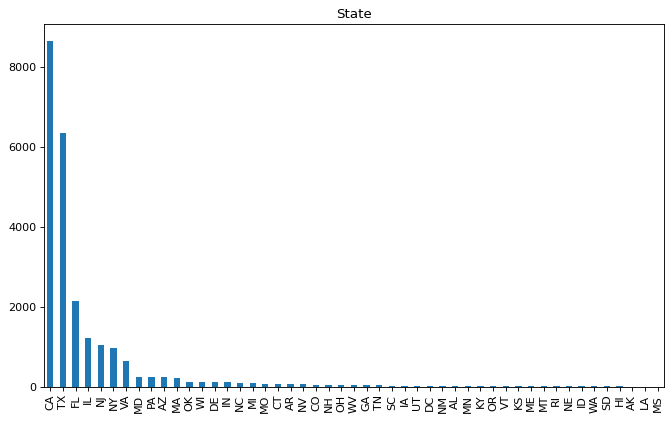

In [12]:
plt.figure(figsize=(10, 6), dpi=80)
plt.title("State")

df['user_state'].value_counts().plot(kind='bar')
plt.show()

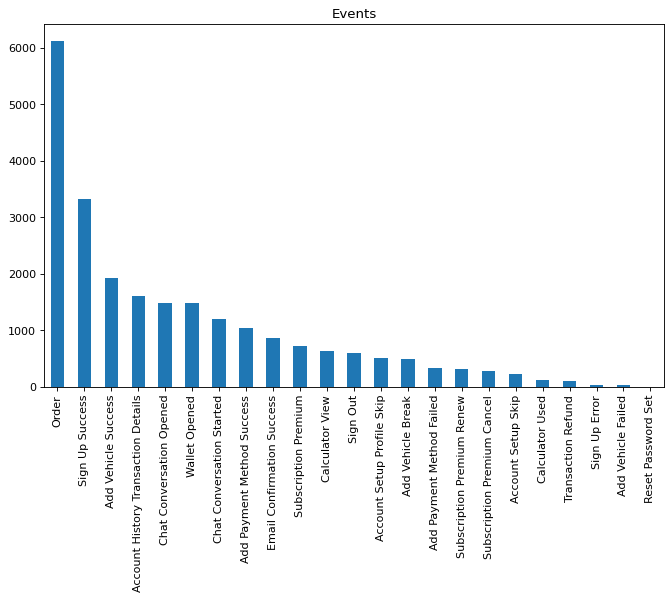

In [13]:
plt.figure(figsize=(10, 6), dpi=80)
plt.title("Events")

df['event_name'].value_counts().plot(kind='bar')
plt.show()

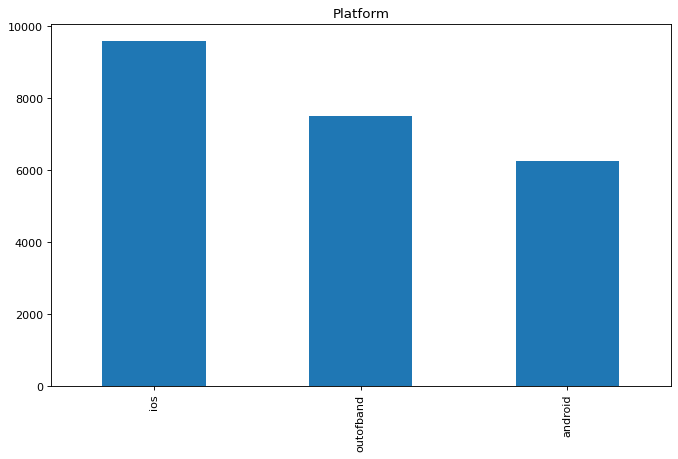

In [14]:
plt.figure(figsize=(10, 6), dpi=80)
plt.title("Platform")

df['event_platform'].value_counts().plot(kind='bar')
plt.show()

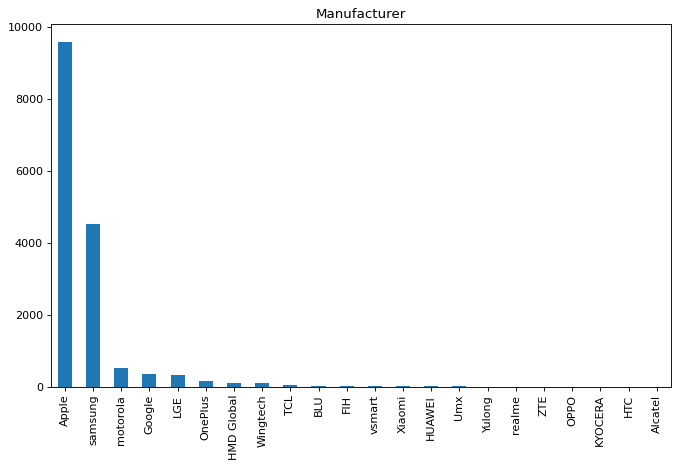

In [15]:
plt.figure(figsize=(10, 6), dpi=80)
plt.title("Manufacturer")

df['device_manufacture'].value_counts().plot(kind='bar')
plt.show()

## Processed data containing only subscribed users

In [16]:
df_target = df[(df['userid'].isin(sub_id)) | (df['userid'].isin(cancel_id))].copy()
df_target['canceled'] = df_target['userid'].apply(lambda x: True if x in cancel_id else False)
t = df_target['canceled'].value_counts()
subscribed_count, unsubscribed_count = t[False],t[True]
print(f'Number of events corresponding to users that have not been unsubsribed: {subscribed_count}')
print(f'Number of events corresponding to users that have been unsubsribed: {unsubscribed_count}')

Number of events corresponding to users that have not been unsubsribed: 9535
Number of events corresponding to users that have been unsubsribed: 5154


In [17]:
print('Most frequently occured event before cancellation')
(df_target.loc[df_target['canceled'] == True, 'event_name'].value_counts()) / unsubscribed_count * 100

Most frequently occured event before cancellation


Chat Conversation Opened               14.338378
Order                                  13.523477
Chat Conversation Started              13.504075
Account History Transaction Details    10.593714
Wallet Opened                           9.972837
Subscription Premium Cancel             5.258052
Sign Out                                4.967016
Add Payment Method Success              4.889406
Add Vehicle Success                     4.481956
Subscription Premium                    4.326737
Sign Up Success                         4.287932
Calculator View                         2.638727
Transaction Refund                      1.882033
Email Confirmation Success              1.338766
Account Setup Profile Skip              1.086535
Add Vehicle Break                       1.067132
Subscription Premium Renew              0.698487
Add Payment Method Failed               0.523865
Calculator Used                         0.388048
Account Setup Skip                      0.194024
Sign Up Error       

In [18]:
print('Most frequently occured event when we are not aware of cancellation event occurance (it may hapen but we dont have this data. So the greater dataset size (timeline) the data is more correct)')
(df_target.loc[df_target['canceled'] == False, 'event_name'].value_counts()) / subscribed_count * 100

Most frequently occured event when we are not aware of cancellation event occurance (it may hapen but we dont have this data. So the greater dataset size (timeline) the data is more correct)


Order                                  45.149449
Account History Transaction Details     9.449397
Wallet Opened                           6.827478
Add Vehicle Success                     5.820661
Add Payment Method Success              5.537493
Subscription Premium                    5.117986
Sign Up Success                         4.866282
Chat Conversation Opened                3.953854
Subscription Premium Renew              2.873623
Calculator View                         2.558993
Chat Conversation Started               2.191924
Email Confirmation Success              1.489250
Add Vehicle Break                       1.059255
Sign Out                                1.048768
Add Payment Method Failed               0.702674
Calculator Used                         0.587310
Account Setup Profile Skip              0.576822
Account Setup Skip                      0.094389
Add Vehicle Failed                      0.041951
Transaction Refund                      0.031463
Sign Up Error       

## Parsing attributes

Event attributes are in JSON format. It is not useful for visualizations and other kinds of work, so let's add them as dataset fields.

In [19]:
ds_withattributes = df.copy()
events = df['event_name'].unique()
for event in events:
    ds_curevent = df[df['event_name'] == event]
    stdf = ds_curevent['event_attributes'].apply(json.loads)
    ds_curevent_attributes = pd.DataFrame(stdf.tolist())
    ds_curevent_attributes = ds_curevent_attributes.set_index(ds_curevent.index)
    new_columns = [event +"_" + name for name in ds_curevent_attributes.columns]
    ds_curevent_attributes = ds_curevent_attributes.set_axis(new_columns, axis=1)
    ds_withattributes = pd.merge(ds_withattributes, ds_curevent_attributes, left_index=True, right_index=True, how="outer")

In [20]:
ds_withattributes.sample(10)

,userid,user_state,event_name,event_attributes,event_created_date,event_platform,device_manufacture,device_model,Add Vehicle Success_Make,Add Vehicle Success_Model,Add Vehicle Success_Color,Add Vehicle Success_Year,Add Vehicle Success_Temporary,Add Vehicle Success_Start Date,Add Vehicle Success_End Date,Add Vehicle Success_Rental state,Add Vehicle Success_Rental State,Add Payment Method Success_Payment Method,Add Payment Method Success_Tokenized Pay,Add Payment Method Success_Promo code,Sign Up Success_Method,Add Payment Method Failed_Error Code,Add Payment Method Failed_Payment Method,Add Payment Method Failed_Error Message,Add Payment Method Failed_Tokenized Pay,Transaction Refund_Id,Transaction Refund_Amount,Email Confirmation Success_Required,Subscription Premium_Start Date,Subscription Premium_Renewal Date,Subscription Premium_Membership Type,Chat Conversation Opened_From,Chat Conversation Opened_Transaction type,Chat Conversation Opened_Transaction Type,Account Setup Profile Skip_Screen,Account History Transaction Details_Type,Account History Transaction Details_Navigated From,Account History Transaction Details_Status,Sign Out_Type,Order_Premium Membership,Sign Up Error_Method,Sign Up Error_Description,Calculator Used_Google Map Installed,Calculator Used_Selected Route Type,Subscription Premium Renew_Start Date,Subscription Premium Renew_Renewal Date,Subscription Premium Renew_Membership Type,Add Vehicle Failed_Error Code,Add Vehicle Failed_Error Message
6188,b8cdde221aae75d37c0996c030e05521,TX,Order,"{""Premium Membership"":""True""}",2022-02-18 07:40:25,outofband,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14284,7b86433951831429fc9a935625c31f77,FL,Order,"{""Premium Membership"":""True""}",2022-03-20 08:21:36,outofband,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5511,dde22c502d2ad606c63a9ab56586cb9a,CA,Chat Conversation Opened,"{""From"":""Menu""}",2022-02-20 00:32:25,ios,Apple,"iPhone13,3",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Menu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22224,cef3c13a885053350dd68b3ce64eddc7,VA,Chat Conversation Opened,"{""From"":""Menu""}",2022-04-13 03:00:21,ios,Apple,"iPhone9,2",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Menu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20672,4b98d821327ceee07c9356467b38baaa,TX,Order,"{""Premium Membership"":""True""}",2022-04-08 05:55:04,outofband,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14228,2c597755067d64bf12050cbd7b62c30f,MD,Add Vehicle Success,"{""Year"":""2019"",""Model"":""MAZDA3"",""Temporary"":""f...",2022-03-16 15:08:47,ios,Apple,"iPhone12,8",Mazda,MAZDA3,Black,2019,false,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3457,2b4ff6dc7c360d31205d3a219bd41cf7,IL,Add Vehicle Success,"{""Year"":""2010"",""Model"":""Malibu"",""Temporary"":""f...",2022-02-10 10:20:13,ios,Apple,"iPhone10,2",Chevrolet,Malibu,Black,2010,false,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17316,410ff2f2d9e4f17566eeee53bed279fd,TX,Order,"{""Premium Membership"":""True""}",2022-03-27 15:30:36,outofband,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7375,40bb760dcafe2254a0dfe804eac23a33,TX,Wallet Opened,{},2022-02-21 20:31:48,ios,Apple,

Visualizations of the parsed attributes sample.

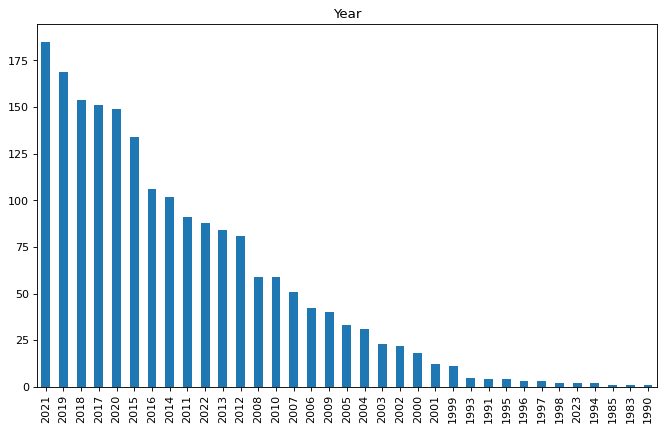

In [21]:
plt.figure(figsize=(10, 6), dpi=80)
plt.title("Year")

ds_withattributes['Add Vehicle Success_Year'].value_counts().plot(kind='bar')
plt.show()

## N-gram frequences

For this part of the research, we have created N-length sequences of events called N-grams. We are trying to figure out what is the most occurring event before the cancellation or the most frequent N-event sequences that precede the cancellation event.

### Function for N-grams creation

Let's select only target events in one dataframe

In [22]:
ds_withattributes = ds_withattributes.sort_values('event_created_date', ascending=True).copy().reset_index()

In [23]:
df_canceled = ds_withattributes[ds_withattributes['event_name'] == 'Subscription Premium Cancel']

In [24]:
def print_ngrams(ngram_len = MAX_EVENTS_SEQ_COUNT):
    prev = []
    for info in df_canceled.iterrows():
        uuid = info[1]['userid']
        id = info[0]
        prev_actions = ds_withattributes.loc[:id - 1]
        prev_actions = prev_actions[prev_actions['userid'] == uuid].tail(ngram_len)
        prev_actions_names = prev_actions.loc[:, 'event_name'].to_numpy()
        res = ""
        if len(prev_actions_names) >= 1:
            res = prev_actions_names[0]
        for action in prev_actions_names[1:]:
            res += "-" + action
        prev.append(res)
    df_canceled.loc[:, 'previous'] = np.array(prev)
    return df_canceled['previous'].value_counts()

### Function usage

Here are N-grams of size 3:

In [25]:
print_ngrams()

Wallet Opened-Chat Conversation Opened-Chat Conversation Started                                               17
Chat Conversation Opened-Chat Conversation Started-Chat Conversation Opened                                    13
Chat Conversation Started-Chat Conversation Started-Chat Conversation Started                                  11
Account History Transaction Details-Chat Conversation Opened-Chat Conversation Started                          9
Chat Conversation Opened-Chat Conversation Started-Wallet Opened                                                8
Wallet Opened-Chat Conversation Started-Chat Conversation Started                                               7
Account History Transaction Details-Account History Transaction Details-Wallet Opened                           7
Chat Conversation Started-Chat Conversation Opened-Chat Conversation Opened                                     6
Subscription Premium-Chat Conversation Opened-Chat Conversation Started                 

Here are N-grams of size 2:

In [26]:
print_ngrams(2)

Chat Conversation Opened-Chat Conversation Started                         56
Chat Conversation Started-Chat Conversation Started                        25
Chat Conversation Started-Chat Conversation Opened                         20
Account History Transaction Details-Wallet Opened                          19
Chat Conversation Opened-Chat Conversation Opened                          16
Wallet Opened-Wallet Opened                                                15
Chat Conversation Started-Wallet Opened                                    13
Chat Conversation Started-Transaction Refund                                9
Wallet Opened-Chat Conversation Started                                     7
Chat Conversation Opened-Sign Out                                           6
Chat Conversation Started-Sign Out                                          5
Wallet Opened-Chat Conversation Opened                                      5
Chat Conversation Opened-Subscription Premium Cancel            

Some data insights from the N-grams:

*   Chat conversation opened, wallet opened, conversation started actions appear in a great number of top action sequences leading to the subscription termination.
*   Account transaction history opened and sign out may also be a sign of termination of subscription in the nearest future.
* It's important to research attribute impact on subscription termination with top frequency events leading to it.